In [45]:
import os
import json
import requests
from typing import List, Dict, Any, TypedDict, Annotated
from typing_extensions import TypedDict


from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain.schema import Document
from langchain_core.prompts import PromptTemplate

from langgraph.graph import StateGraph, END, START
# from langgraph.prebuilt import ToolExecutor, tools
from langgraph.checkpoint.memory import MemorySaver
from sentence_transformers import SentenceTransformer, util
import operator
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.constants import Send
from pydantic import BaseModel, Field

from duckduckgo_search import DDGS
import wikipediaapi


In [2]:
import dotenv
dotenv.load_dotenv()
HF_TOKEN = os.getenv("HF_TOKEN")
GENAI_API_KEY = os.getenv("GENAI_API_KEY")
IMAGE_CAPTION_API_URL = "https://api-inference.huggingface.co/models/Salesforce/blip-image-captioning-large"

In [3]:
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", google_api_key=GENAI_API_KEY)

In [46]:
class CaptionState(TypedDict):
    image_path: str
    advanced_context: str
    basic_context: str
    region: str
    retrieved_captions: List[str]
    caption: str
    context: Annotated[List[str], operator.add]
    rag_content: str
    query: Dict[str, Any]
    hashtags: List[str]
    error: str
    
class QueryOutput(BaseModel):
    """Schema for query generation output."""
    web_query: str = Field(description="Query to search the web for festival information")
    wiki_query: str = Field(description="Query to search Wikipedia for festival information")

In [ ]:
def extract_image_context(state: CaptionState) -> CaptionState:
    """Extract caption/context from an image using HuggingFace model."""
    print("Extracting image context...")
    try:
        image_path = state["image_path"]
        
        print("1")
        print(f"Image path: {image_path}")
        
        with open(image_path, "rb") as image_file:
            image_bytes = image_file.read()

        response = requests.post(
            IMAGE_CAPTION_API_URL,
            headers={"Authorization": f"Bearer {HF_TOKEN}"},
            data=image_bytes
        )

        print("2")
        
        if response.status_code != 200:
            state["error"] = f"Error extracting context: {response.text}"
            return state

        result = response.json()
        state["basic_context"] = " ".join(result[0]['generated_text'].split(" ")[1:])
        
        return {"basic_context": state["basic_context"]}
    except Exception as e:
        print(f"Error processing image: {str(e)}")
        state["error"] = f"Error processing image: {str(e)}"
        ###
        state["basic_context"] = "colours flying everywhere"
        return state

In [48]:
def QueryAgent(state: CaptionState):
    
    context = f"""
    The basic contedxt extracted from the image is as follows:
    {state["basic_context"]}
    
    The advanced context provided by the user is as follows:
    {state["advanced_context"]}
    """
    
    system_prompt = """You are an helpful agent that can ask questions 
    to the web and Wikipedia to gather information about a given festival.
    
    You will be provided with a context about the festival, and you will use that context to
    generate queries to search the web and Wikipedia for more information.
    
    The context is as follows:
    {context}
    Your task is to generate two queries:
    1. A web query to search the web for more information about the festival.
    2. A Wikipedia query to search Wikipedia for more information about the festival.\
    """
    
    structured_llm = llm.with_structured_output(QueryOutput)
    
    response = structured_llm.invoke([
        SystemMessage(
            system_prompt.format(context=context)

    )] + [
        HumanMessage(
            content="Generate web and Wikipedia queries based on the provided context."
        )]
    )
    
    query = {
            "web_query": response.web_query.strip(),
            "wiki_query": response.wiki_query.strip()
        }
        
    print(f"Generated web query: {query['web_query']}")
    print(f"Generated Wikipedia query: {query['wiki_query']}")
    
    return {"query": query}

In [32]:
def extract_from_RAG(state: CaptionState):
    return {"rag_content": "Relevant content extracted from RAG"}


In [ ]:
def web_search(state: CaptionState):
    """Perform a web search using DuckDuckGo."""
    try:
        query = state["query"]["web_query"]
        print(f"Performing web search for query: {query}")
        results = DDGS().text(query, max_results=5)
        
        if not results:
            state["error"] = "No results found for the web search."
            return state
            
        print(f"Found {len(results)} results for web search.")
        # Extract the body of each result
        for result in results:
            print(f"Result: {result['body'][:100]}...")
            
        return {"context": [result['body'] for result in results]}
        
    except Exception as e:
        print(f"Error during web search: {str(e)}")
        state["error"] = f"Error during web search: {str(e)}"
        return state


def wiki_search(state: CaptionState):
    """Perform a Wikipedia search."""
    try:
        query = state["query"]["wiki_query"]
        print(f"Performing Wikipedia search for query: {query}")
        
        # Fix: Specify a proper user agent
        wiki_wiki = wikipediaapi.Wikipedia(
            user_agent='CaptionBot/1.0 (your-app-name@example.com)',
            language='en'
        )
        
        page = wiki_wiki.page(query)
        
        if not page.exists():
            state["error"] = "No results found for the Wikipedia search."
            return state
            
        print(f"Found Wikipedia page: {page.title}")
        print(f"Summary: {page.summary[:100]}...")
        
        return {"context": [page.summary]}
        
    except Exception as e:
        print(f"Error during Wikipedia search: {str(e)}")
        state["error"] = f"Error during Wikipedia search: {str(e)}"
        return state

In [41]:
def conditional_node(state: CaptionState):
    return [
        Send("web_search", state),
        Send("wiki_search", state)
    ]

In [ ]:
def generate_caption(state: CaptionState) -> CaptionState:
    """Generate a culturally-aware caption based on contexts and examples."""
    try:
        combined_context = f"""
        The basic context extracted from the image is as follows:
        {state["basic_context"]}
        The advanced context provided by the user is as follows:
        {state["advanced_context"]}
        The region of the festival is: {state["region"]}
        
        The extracted context from the web and Wikipedia queries is as follows:
        {state["context"]}
        """

        prompt = PromptTemplate(
            input_variables=["combined_context"],
            template="""
            You are an assistant that generates culturally-aware Instagram captions and hashtags.

            You specialize in festival posts.

            Follow these steps:
            Step 1: Identify any culturally significant objects, elements, or symbolism in the visual and textual description.
            Step 2: Infer if any specific culture, tradition, or festival is likely related.
            Step 3: If the advanced context supports a cultural interpretation, incorporate it in the caption.
            Step 4: Generate an engaging, original Instagram caption (without hashtags) that captures the cultural or emotional essence.

            Combined context from image, user, web and wikipedia:
            {combined_context}

            Respond with just the caption. Make it conversational, authentic, and attention-grabbing. Keep it under 150 characters.
            """
        )

        formatted_prompt = prompt.format(
            combined_context=combined_context
        )

        response = llm.invoke(formatted_prompt)
        state["caption"] = response.content.strip()
        return state
    except Exception as e:
        state["error"] = f"Error generating caption: {str(e)}"
        return state

In [29]:
def generate_hashtags(state: CaptionState) -> CaptionState:
    """Generate relevant hashtags based on caption and category."""
    try:
        caption = state["caption"]
        
        prompt = PromptTemplate(
            input_variables=["context"],
            template="""
            You are a hashtag specialist for Instagram festival posts.

            Here's the caption: 
            {caption}

            Generate 5-7 relevant, trending hashtags for the caption.
            Include both popular general hashtags and specific ones related to the content.
            Return only the hashtags as a comma-separated list without explanation or numbering.
            Each hashtag should start with # and have no spaces.
            """
        )

        formatted_prompt = prompt.format(
            caption=caption,
        )

        response = llm.invoke(formatted_prompt)
        hashtags = [tag.strip() for tag in response.content.replace("\n", " ").split(",") if tag.strip()]
        state["hashtags"] = hashtags
        return state
    except Exception as e:
        state["error"] = f"Error generating hashtags: {str(e)}"
        return state

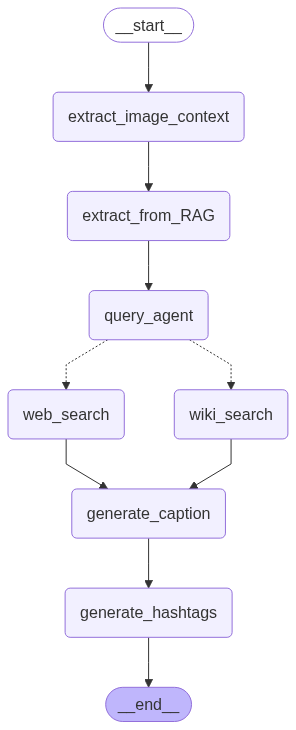

In [42]:
workflow = StateGraph(CaptionState)

workflow.add_node("extract_image_context", extract_image_context)
workflow.add_node("query_agent", QueryAgent)
workflow.add_node("extract_from_RAG", extract_from_RAG)
workflow.add_node("web_search", web_search)
workflow.add_node("wiki_search", wiki_search)
workflow.add_node("generate_caption", generate_caption)
workflow.add_node("generate_hashtags", generate_hashtags)

workflow.add_edge(START, "extract_image_context")
workflow.add_edge("extract_image_context", "extract_from_RAG")
workflow.add_edge("extract_from_RAG", "query_agent")
workflow.add_conditional_edges(
    "query_agent",
    conditional_node,
    ["web_search", "wiki_search"]
)
workflow.add_edge("web_search", "generate_caption")
workflow.add_edge("wiki_search", "generate_caption")
workflow.add_edge("generate_caption", "generate_hashtags")
workflow.add_edge("generate_hashtags", END)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))